# Pixel drill using interactive widgets

**What does this notebook do?** 

This notebook demonstrates how to perform a pixel drill using an interactive widget. A plot is drawn up of a single time slice for Canberra so the user can select a pixel to interrogate further. Once a pixel is selected, a timeseries is plotted up for that pixel, using the green band as an example. Users can then select a point in the time series plot to generate a plot showing the corresponding satellite image for that point in time.

This notebook is adapted from a Digital Earth Australia example by Claire Krause

In [1]:
%pylab notebook

from datacube import Datacube
from datacube.storage import masking

import pandas as pd

# Import widgets for interactive notebook
from ipywidgets import interact, fixed
import ipywidgets as widgets

# Import the custom script for plotting. This script can be found in the dea-notebooks repository.
# import sys
# import os.path
# sys.path.append(os.path.expanduser('~/dea-notebooks/10_Scripts'))
# import DEAPlotting

dc = Datacube(app='pixel_drill')

Populating the interactive namespace from numpy and matplotlib


/home/jovyan/.local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## Set up the extraction query

In [2]:
query = {'lat': (-35.25, -35.35),
         'lon': (149.05, 149.17),
         'output_crs': 'EPSG:3577',
         'resolution': (-30, 30)} 


## First, pull in the data from Landsat 8

Note that for simplicity, the data have not been cloud filtered in this example.

In [3]:
data = dc.load(product='ls8_usgs_sr_scene', group_by='solar_day', **query)
# Set all nodata pixels to `NaN`:
data = masking.mask_invalid_data(data)
# Set all invalid data to `NaN` - valid range for USRS SR is 0 to 10000, but the surface reflectance product can have values just outside this range
# We remove them so the image drawn isn't impacted by them
data = data.where((data >= 0) & (data<=10000))

In [4]:
data

<xarray.Dataset>
Dimensions:          (time: 48, x: 410, y: 417)
Coordinates:
  * time             (time) datetime64[ns] 2017-09-04T23:50:24.564670 ...
  * y                (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x                (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    coastal_aerosol  (time, y, x) float64 187.0 89.0 69.0 257.0 271.0 431.0 ...
    blue             (time, y, x) float64 233.0 277.0 382.0 518.0 447.0 ...
    green            (time, y, x) float64 481.0 567.0 689.0 806.0 726.0 ...
    red              (time, y, x) float64 580.0 548.0 751.0 1.063e+03 923.0 ...
    nir              (time, y, x) float64 2.115e+03 2.291e+03 2.447e+03 ...
    swir1            (time, y, x) float64 1.357e+03 1.516e+03 1.891e+03 ...
    swir2            (time, y, x) float64 956.0 1.01e+03 1.317e+03 1.277e+03 ...
    pixel_qa         (time, y, x) float64 322.0 322.0 322.0 322.0 322.0 ...
    sr_aerosol       (time, y, x) float64 228.0 228.0

## Plot up an image so we can select a pixel for further interrogation

### First, we want to define a function called `onclick` that specifies what happens when the plot is clicked

Click on the pixel you would like to interrogate


<IPython.core.display.Javascript object>


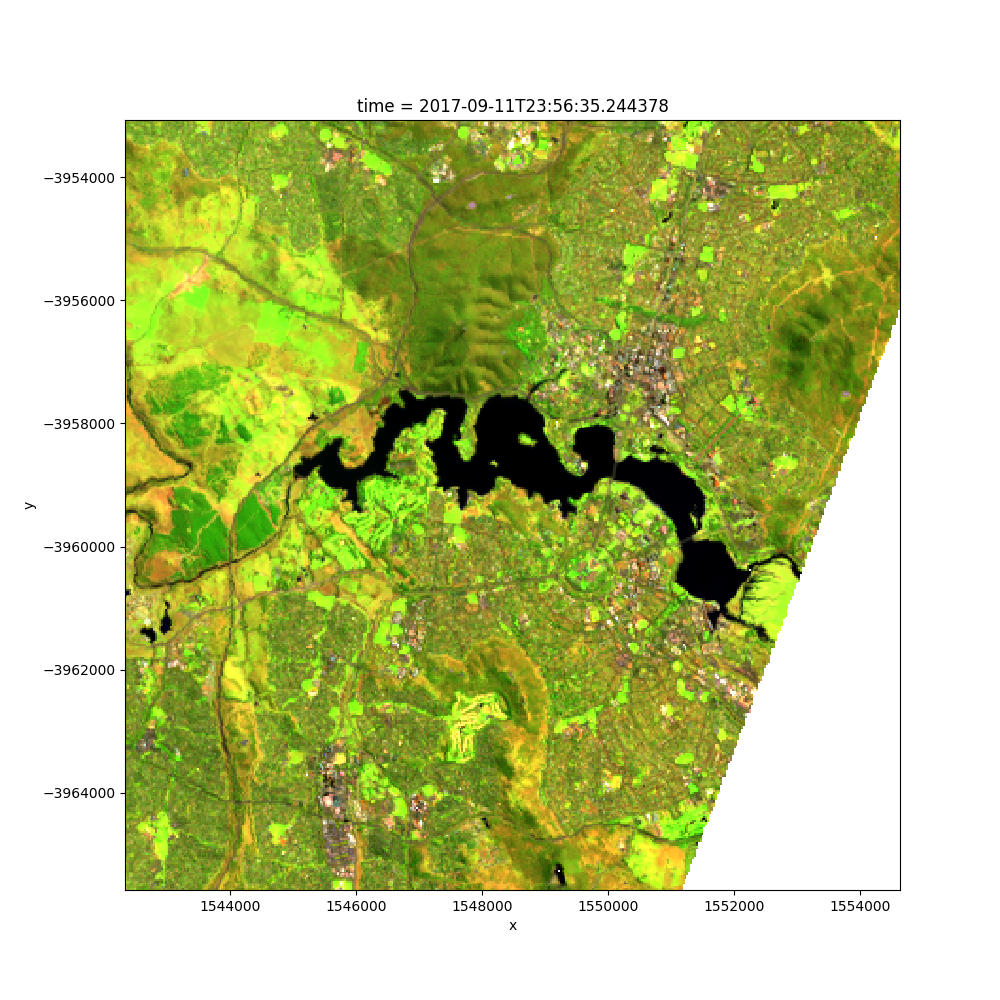

HTML(value='Click on the pixel you would like to interrogate')

In [95]:
def onclick(event):
    global pixelx, pixely
    pixelx, pixely = int(event.xdata), int(event.ydata)
    w.value = 'pixelx : {}, pixely : {}'.format(pixelx, pixely)

print('\033[1m' + 'Click on the pixel you would like to interrogate' + '\033[0m')

image_array = data[['swir1', 'nir', 'green']].isel(time=1).to_array()
# Show the image
image_array.plot.imshow(robust=True, figsize=(10, 10))

fig = plt.gcf()
w = widgets.HTML("Click on the pixel you would like to interrogate")
cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

## Plot up the complete timeseries of data for a single pixel

For the sake of this demonstration, we just choose to plot up the `green` spectral band. This workflow would also work for an index, like NDVI.

<IPython.core.display.Javascript object>


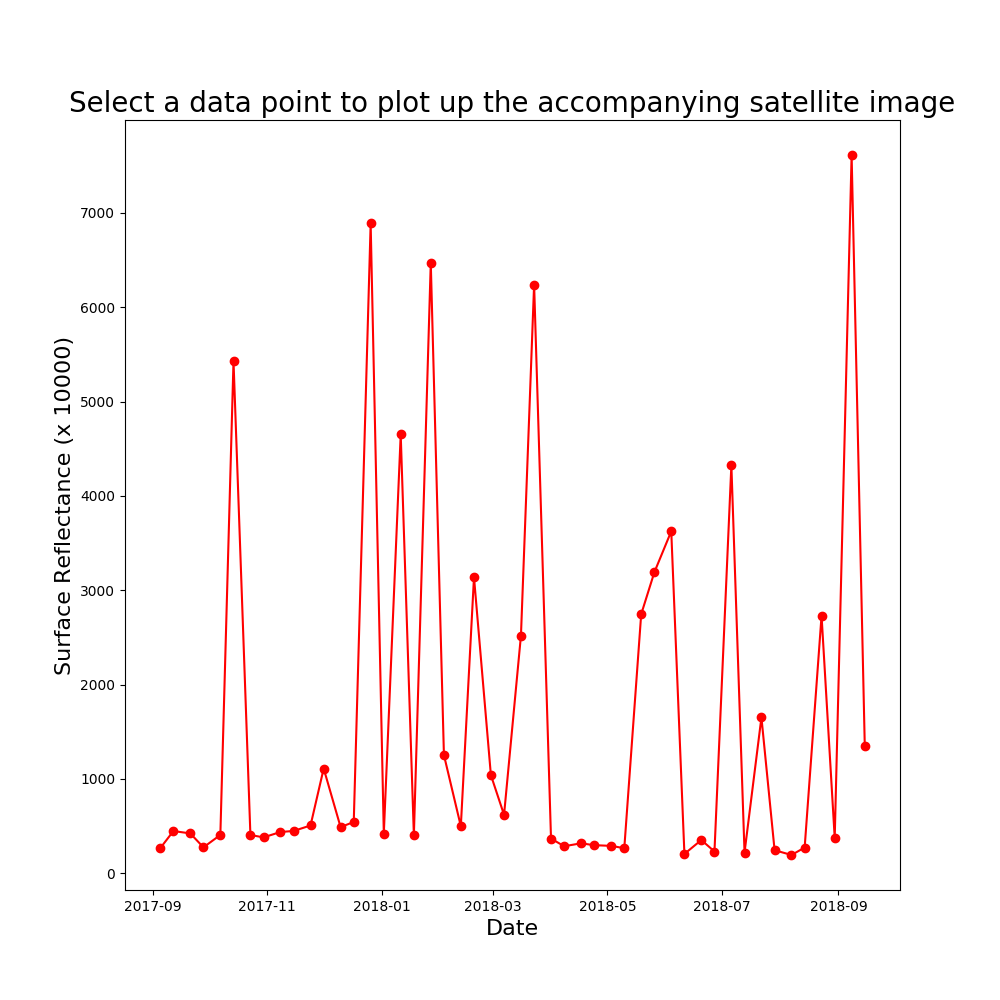

HTML(value='Click on the time you would like to display')

In [97]:
fig = plt.figure(figsize=[10, 10])

plt.plot(data.time, data.green.sel(
    y=pixely, x=pixelx, method='nearest'), 'ro-')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Surface Reflectance (x 10000)', fontsize=16)
plt.title(
    'Select a data point to plot up the accompanying satellite image', fontsize=20)

w = widgets.HTML("Click on the time you would like to display")


def onclick(event):
    global timeOfInterest
    timeOfInterest = event.xdata
    w.value = 'time of interest : {}'.format(timeOfInterest)


cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

<div class="alert alert-info">

**Note:** In this example, we have not filtered out clouds. You can see in the above plot that there are a lot of values clustered around ~1000, then values up to ~10,000. If you click through these pixels, you will notice that these higher values are actually images where the scene is cloudy. The collection of values ~1000 represent the scenes where the sensor had a clear image of the pixel chosen, and so represent actual ground green band values. If we had filtered out the cloud impacted scenes, the values > ~1000 would be removed, as would the values below zero, which represent missing values for the chosen pixel.

</div>

## Plot the scene that matches the selected time and sensor

<IPython.core.display.Javascript object>


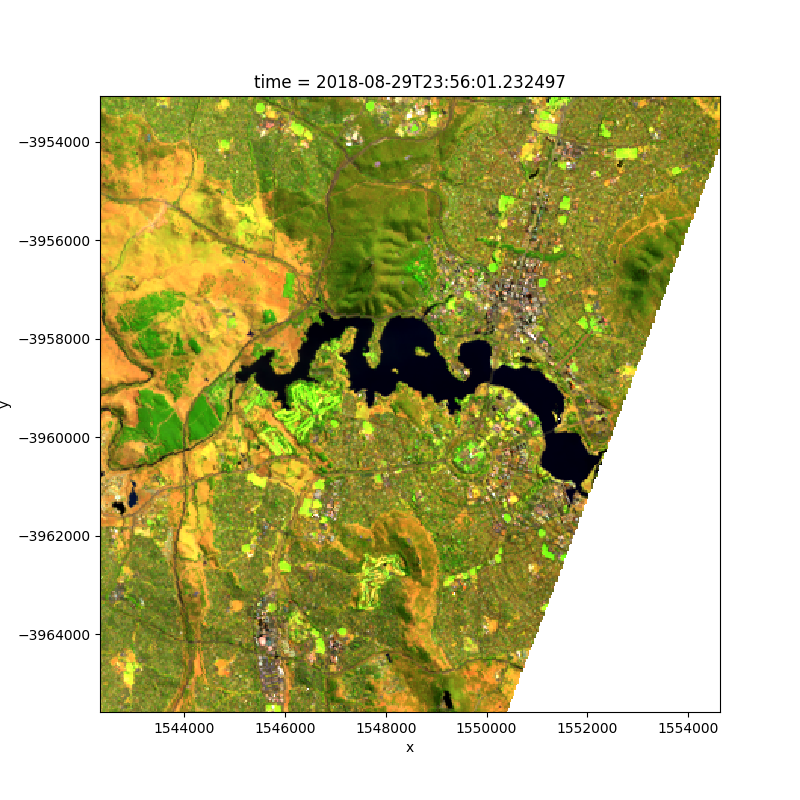

In [103]:
#Convert the selected time to a time stamp we can use to extract the correct scene
# Convert clicked int to datetime format
time_slice = matplotlib.dates.num2date(timeOfInterest).date()
# Convert clicked value to str
time_slice = str(time_slice)
# Convert clicked value to correct datetime format
time_slice = datetime64(time_slice, 'ns')

image_array = data[['swir1', 'nir', 'green']].sel(time=time_slice, method='nearest').to_array()
# Show the image
image_array.plot.imshow(robust=True, figsize=(8, 8))
